In [42]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# 1. Read in data set, explore

In [43]:
# Load the processed data

df_telecom = pd.read_csv('../churn_clean.csv') #telecom_data1.csv')

In [44]:
df_telecom.head(3)

,Unnamed: 0,ID,Customer_id,Interaction,UID,zip,Lat,Lng,City,State,Population,County,Area,Timezone,Job,Children,Age,Education,Employment,Income,Marital,Churn,Gender,outage_sec_perweek,email,contacts,yearly_equip_failure,Techie,Contract,Port_modem,Tablet,InternetService,Phone,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,Tenure,MonthlyCharge,Bandwidth_GB_Year,item1,item2,item3,item4,item5,item6,item7,item8
0,1,1,K409198,27a5a3df-e3a8-4265-9b21-ae1687add97b,fc19038b2266586dbd57ec16be42857a,42541,37.37150,-84.79765,Middleburg,KY,590,Casey,Rural,America/New_York,Retail merchandiser,2,22,Associate's Degree,Full Time,24892.19,Divorced,No,Male,7.978323,10,0,1,No,One year,Yes,Yes,Fiber Optic,Yes,No,Yes,Yes,No,No,No,Yes,Yes,Credit Card (automatic),6.795513,89.979239,1127.483426,2,2,3,3,3,2,4,3
1,2,2,S120509,339285d9-291c-4938-9b9e-04d798ed0f3b,946ac10fa471b4fd494fd399542a2e91,6238,41.78306,-72.33955,Coventry,CT,12396,Tolland,Suburban,America/New_York,Hospital pharmacist,4,72,Bachelor's Degree,Full Time,6998.09,Widowed,No,Female,11.699080,12,0,1,Yes,Month-to-month,No,Yes,Fiber Optic,Yes,Yes,Yes,No,No,No,Yes,Yes,Yes,Bank Transfer(automatic),1.156681,100.156274,858.721292,3,3,4,3,3,4,3,2
2,3,3,K191035,bf06b719-1f9d-4262-b439-a321e3acf452,f818cb2ad580bd01fd0510f289ca2cd7,48842,42.63384,-84.53866,Holt,MI,21827,Ingham,Rural,America/Detroit,"Loss adjuster, chartered",3,84,Nursery School to 8th Grade,Student,54665.60,Married,Yes,Female,10.752800,9,0,1,Yes,Two Year,Yes,No,DSL,Yes,Yes,No,No,No,No,No,Yes,Yes,Credit Card (automatic),15.754144,99.947583,2095.500119,4,5,4,2,4,3,3,3


In [4]:
#df_telecom.describe()
#df_telecom.dtypes

In [45]:
# Define features and target variables

X = df_telecom.drop('Churn',axis=1)   #Feature Matrix
Y = df_telecom['Churn']          #Target Variable

# Print dimensions
print(X.shape)
print(Y.shape)

(10000, 52)
(10000,)


# 2. Feature Engineering

## Variable transformation 

In [46]:
# Transform Y to 0/1

Y = pd.Series(np.where(Y.values=='Yes',1,0))

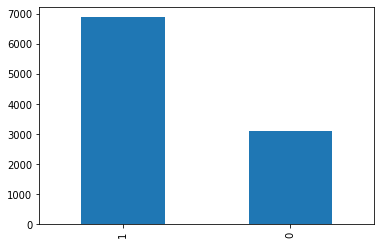

In [47]:
# Percent counts of Y
Y.value_counts().plot(kind='bar')

In [48]:
# transform zip to categorical

X['zip']= X['zip'].astype('str')

## Variable selection

### Continuous variables

In [51]:
cols_cont = X.select_dtypes([np.number]).drop(['Unnamed: 0', 'ID'], axis=1).columns.values.tolist() #only numeric
cols_cont = cols_cont[:-8] #remove items 
cols_cont

['Lat',
 'Lng',
 'Population',
 'Children',
 'Age',
 'Income',
 'outage_sec_perweek',
 'email',
 'contacts',
 'yearly_equip_failure',
 'Tenure',
 'MonthlyCharge',
 'Bandwidth_GB_Year']

In [52]:
# Cont cols (normalize for KNN)

# Continuous cols (normalize-for KNN)
X_cont = X[cols_cont]
X_cont.head(3)

,Lat,Lng,Population,Children,Age,Income,outage_sec_perweek,email,contacts,yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year
0,37.37150,-84.79765,590,2,22,24892.19,7.978323,10,0,1,6.795513,89.979239,1127.483426
1,41.78306,-72.33955,12396,4,72,6998.09,11.699080,12,0,1,1.156681,100.156274,858.721292
2,42.63384,-84.53866,21827,3,84,54665.60,10.752800,9,0,1,15.754144,99.947583,2095.500119


### Categorical variables

In [53]:
# Cat cols-full list

cols_cat_all = X.loc[:, X.dtypes == np.object].columns.values.tolist() #have to translate back to list format
cols_cat_all = cols_cat_all[3:] #remove the first three cols, related to cust ID


In [54]:
# Cat cols-only those with limited tot unique value (otherwise too many categories created for dummies)

t = X[cols_cat_all].nunique().sort_values(ascending=False)
t = t.loc[lambda t: t < 20]  # change value to what is desired here, from 20
cols_cat_all_red = t.index.values.tolist()
X[cols_cat_all_red].nunique().to_frame('tot unique') #updated reduced list 


,tot unique
Education,12
Marital,5
Employment,5
PaymentMethod,4
InternetService,3
Gender,3
Area,3
Contract,3
Tablet,2
Port_modem,2


In [55]:
# 1. Create dummies-for categorical cols (use reduced col list)

X_cat = pd.get_dummies(X[cols_cat_all_red], drop_first=True) # drop first as it is redundant
print('number of cat cols chosen: ', X[cols_cat_all_red].shape[1])
print('total cat cols after one hot encoding: ', X_cat.shape[1])
X_cat.head(3)

number of cat cols chosen:  20
total cat cols after one hot encoding:  42


,Education_Associate's Degree,Education_Bachelor's Degree,Education_Doctorate Degree,Education_GED or Alternative Credential,Education_Master's Degree,Education_No Schooling Completed,Education_Nursery School to 8th Grade,Education_Professional School Degree,Education_Regular High School Diploma,"Education_Some College, 1 or More Years, No Degree","Education_Some College, Less than 1 Year",Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,Employment_Part Time,Employment_Retired,Employment_Student,Employment_Unemployed,PaymentMethod_Credit Card (automatic),PaymentMethod_Electronic Check,PaymentMethod_Mailed Check,InternetService_Fiber Optic,InternetService_None,Gender_Male,Gender_Prefer not to answer,Area_Suburban,Area_Urban,Contract_One year,Contract_Two Year,Tablet_Yes,Port_modem_Yes,PaperlessBilling_Yes,Techie_Yes,Phone_Yes,Multiple_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,1,1,0,1,0,1,1,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,1,1,1,0,0,0,1,1
2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,0,0,0,0,1


In [56]:
# 2. For Naive Bayes, choose all cat columns and label encode 

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

X_cat_nb = X[cols_cat_all].apply(le.fit_transform)
print('number of cat cols in NB: ', X[cols_cat_all].shape[1])
print('total cat cols in NB after one hot encoding: ', X_cat_nb.shape[1])
X_cat_nb.head(3) 

number of cat cols in NB:  26
total cat cols in NB after one hot encoding:  26


,zip,City,State,County,Area,Timezone,Job,Education,Employment,Marital,Gender,Techie,Contract,Port_modem,Tablet,InternetService,Phone,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod
0,3136,3438,17,231,0,20,516,1,0,0,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,1
1,5393,1191,6,1425,1,20,301,2,0,4,0,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0
2,3872,2459,22,685,0,5,355,7,3,1,0,1,2,1,0,0,1,1,0,0,0,0,0,1,1,1


In [57]:
# Join Cat and Noncat together

X_all = pd.concat([X_cont, X_cat],axis=1)
X_all_nb = pd.concat([X_cont, X_cat_nb],axis=1)

print('total cols for final df: ', X_all.shape[1]) 
print('total cols for final df, Naive Bayes: ',X_all_nb.shape[1])
X_all_nb.head()

total cols for final df:  55
total cols for final df, Naive Bayes:  39


,Lat,Lng,Population,Children,Age,Income,outage_sec_perweek,email,contacts,yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year,zip,City,State,County,Area,Timezone,Job,Education,Employment,Marital,Gender,Techie,Contract,Port_modem,Tablet,InternetService,Phone,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod
0,37.37150,-84.79765,590,2,22,24892.19,7.978323,10,0,1,6.795513,89.979239,1127.483426,3136,3438,17,231,0,20,516,1,0,0,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,1
1,41.78306,-72.33955,12396,4,72,6998.09,11.699080,12,0,1,1.156681,100.156274,858.721292,5393,1191,6,1425,1,20,301,2,0,4,0,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0
2,42.63384,-84.53866,21827,3,84,54665.60,10.752800,9,0,1,15.754144,99.947583,2095.500119,3872,2459,22,685,0,5,355,7,3,1,0,1,2,1,0,0,1,1,0,0,0,0,0,1,1,1
3,41.16705,-83.39990,18690,7,73,16882.33,14.913540,15,2,0,17.087227,99.956840,2291.169315,3372,1883,35,1290,0,20,554,11,3,1,1,1,2,0,0,0,1,0,1,0,0,0,1,0,1,3
4,43.96925,-69.22844,1537,10,63,99740.63,8.147417,16,2,1,1.670972,87.472036,543.620307,3839,5349,21,758,0,20,412,4,0,2,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,3


# Train/Test Split Data

In [58]:
# Split the data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all, Y,
    test_size=0.3,
    random_state=1
)

# for Naive Bayes
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(
    X_all_nb, Y,
    test_size=0.3,
    random_state=1
)

In [59]:
# Print dimensions

print('Train cols: ', X_train.shape[1])
print('Test cols: ', X_test.shape[1])
print('Train cols, NB: ', X_train_nb.shape[1])
print('Test cols, NB: ', X_test_nb.shape[1])

Train cols:  55
Test cols:  55
Train cols, NB:  39
Test cols, NB:  39


# Predictive Modeling Techniques

# 1. KNN

This section covers KNN

In [60]:
# Load the K-Nearest Neighbors class
from sklearn.neighbors import KNeighborsClassifier

# Load the metrics libraries (used for all methods)
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report

In [61]:
# Scale the data for cols_cont 

from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() #MinMaxScaler()

X_train_std = X_train.copy() #copy train features df for KNN
X_test_std = X_test.copy()  #copy test features df for KNN
#transform cont cols only
X_train_std[cols_cont] = scaler.fit_transform(X_train_std[cols_cont]) 
X_test_std[cols_cont] = scaler.transform(X_test_std[cols_cont])

X_train_std.head(3)

,Lat,Lng,Population,Children,Age,Income,outage_sec_perweek,email,contacts,yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year,Education_Associate's Degree,Education_Bachelor's Degree,Education_Doctorate Degree,Education_GED or Alternative Credential,Education_Master's Degree,Education_No Schooling Completed,Education_Nursery School to 8th Grade,Education_Professional School Degree,Education_Regular High School Diploma,"Education_Some College, 1 or More Years, No Degree","Education_Some College, Less than 1 Year",Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,Employment_Part Time,Employment_Retired,Employment_Student,Employment_Unemployed,PaymentMethod_Credit Card (automatic),PaymentMethod_Electronic Check,PaymentMethod_Mailed Check,InternetService_Fiber Optic,InternetService_None,Gender_Male,Gender_Prefer not to answer,Area_Suburban,Area_Urban,Contract_One year,Contract_Two Year,Tablet_Yes,Port_modem_Yes,PaperlessBilling_Yes,Techie_Yes,Phone_Yes,Multiple_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
2228,-0.248434,0.619757,-0.619249,-0.527321,-0.067341,0.637243,-0.512070,0.333118,0.007498,-0.631386,-0.947131,-0.661935,-1.003136,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,1,0,0,1,1,0,1,0
5910,0.183304,-0.035816,-0.625909,0.382189,0.652189,-0.821174,0.813882,1.324682,0.007498,-0.631386,1.336839,0.505692,1.435018,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0
1950,0.834069,1.337321,0.103541,-0.527321,-0.834840,1.258544,1.207838,1.985725,0.007498,-0.631386,-1.240883,0.522351,-1.159157,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,1,1,1,0,1,0,0,1,1


In [62]:
# Train a K-Nearest Neighbors model

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train_std, y_train) #Note: only X_train is std (not y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [63]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = knn.predict(X_test_std)
y_prob = knn.predict_proba(X_test_std)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))
#confusion_matrix(y_test, y_pred)


total accuracy = 69.9%
total precision = 77.6%
total recall = 77.7%
auc = 0.72%


# 2. Naive Bayes

This section covers Naive Bayes

In [64]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
nb = model.fit(X_train_nb,y_train_nb)

In [65]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = nb.predict(X_test_nb)
y_prob = nb.predict_proba(X_test_nb)[:, 1]

acc = accuracy_score(y_test_nb, y_pred)*100
precision = precision_score(y_test_nb, y_pred)*100
recall = recall_score(y_test_nb, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test_nb, y_prob)
print('auc = {:.2f}%'.format(auc))
#confusion_matrix(y_test, y_pred)

total accuracy = 69.5%
total precision = 83.4%
total recall = 68.1%
auc = 0.76%


# 3. Decision Tree

This section covers Decision Trees

In [66]:
from sklearn.tree import DecisionTreeClassifier

In [67]:
# Train a Random Forest

tree = DecisionTreeClassifier(max_depth=5)

tree.fit(X_train, y_train) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [68]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))
#confusion_matrix(y_test, y_pred)

total accuracy = 74.9%
total precision = 77.1%
total recall = 89.1%
auc = 0.79%


# 4. Random Forest 

This section covers Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
# Train a Random Forest

forest = RandomForestClassifier(
    n_estimators=100,
    max_features=15,
    max_depth=5,
    random_state=1,
)
forest.fit(X_train, y_train) 


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [71]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = forest.predict(X_test)
y_prob = forest.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))
#confusion_matrix(y_test, y_pred)

total accuracy = 75.8%
total precision = 77.6%
total recall = 90.1%
auc = 0.80%


## Feature Importance for Random Forest

In [72]:
feature_imp = pd.Series(forest.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp[:10]

Bandwidth_GB_Year              0.328492
Tenure                         0.315530
InternetService_Fiber Optic    0.170609
MonthlyCharge                  0.050224
Population                     0.015509
Income                         0.012488
Lng                            0.011496
outage_sec_perweek             0.010102
InternetService_None           0.009785
Gender_Male                    0.009514
dtype: float64

No handles with labels found to put in legend.


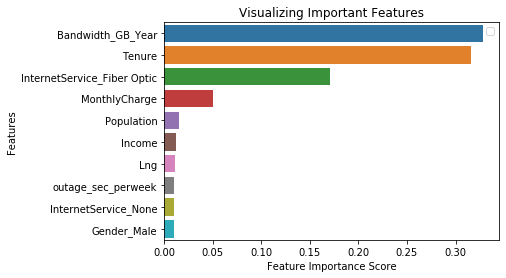

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp[:10], y=feature_imp[:10].index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

# 4. Gradient Boosting (not covered)
This section covers Gradient Boosting

In [74]:
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

## AdaBoost

In [75]:
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=None)

In [76]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = ada.predict(X_test)
y_prob = ada.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))

total accuracy = 75.1%
total precision = 77.7%
total recall = 88.3%
auc = 0.79%


## Gradient boost

In [77]:
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [78]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))

total accuracy = 76.2%
total precision = 78.2%
total recall = 89.6%
auc = 0.80%


In [79]:
gb = GradientBoostingClassifier(n_estimators=100,learning_rate=.02, max_features=15, max_depth=5, random_state=1)
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.02, loss='deviance', max_depth=5,
                           max_features=15, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [80]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))

total accuracy = 75.9%
total precision = 77.1%
total recall = 91.2%
auc = 0.80%
